## Setup of system

In [1]:
import numpy as np
np.set_printoptions(precision=2) # 2 decimals when printing arrays
np.set_printoptions(suppress=True) # No scientific notation for small numbers
import matplotlib.pyplot as plt
from scipy.integrate import complex_ode

from numba import njit

from quantum_systems import ODQD, GeneralOrbitalSystem # library developed by Øyvind Schøyen and others, https://github.com/Schoyen/quantum-systems

import matplotlib.animation as animation
import matplotlib.image as mpimg
from IPython.display import HTML

In [2]:
l_0 = 10                # number of basis functions
grid_length = 10        # compute from x = -10 to x = 10 in 1D
num_grid_points = 2001
omega = 0.25            # strength of harmonic oscillator potential
n = 2                   # number of particles

# this sets up the harmonic oscillator basis functions and integrals between them
odho = ODQD(l_0, grid_length, num_grid_points, a = 0.25, alpha = 1, potential = ODQD.HOPotential(omega))

# this makes a spin up and spin down variant of the odho basis function and sets up the integrals between them
system = GeneralOrbitalSystem(n = n, basis_set=odho)

In [3]:
@njit
def getP(C, n):
    l = C.shape[0]
    P = np.zeros((l, l), dtype="c16")
    
    for a in range(l):
        for b in range(l):
            for i in range(n):
                P[b, a] += np.conj(C[a, i]) * C[b, i]
    return P

@njit
def getF(C, h, u, n):
    l = C.shape[0]
    F = np.zeros((l, l), dtype="c16")
    P = getP(C, n)
    
    F += h
    for a in range(l):
        for b in range(l):
            for c in range(l):
                for d in range(l):
                    F[a, b] += P[d, c] * u[a, c, b, d]
    return F

def SCF(C, system, iters = 20):
    for i in range(iters):
        F = getF(C, system.h, system.u, system.n)
        vals, C = np.linalg.eigh(F)
    return C

In [4]:
C = np.eye(system.l, dtype="c16")

C = SCF(C, system, 20)

'GS 0 coefs: [-0.31  0.88 -0.    0.    0.11 -0.33  0.   -0.   -0.03  0.08 -0.    0.  0.   -0.   -0.    0.    0.   -0.   -0.    0.  ]'

'GS 1 coefs: [ 0.88  0.31 -0.   -0.   -0.33 -0.11  0.    0.    0.08  0.03 -0.   -0. -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.  ]'

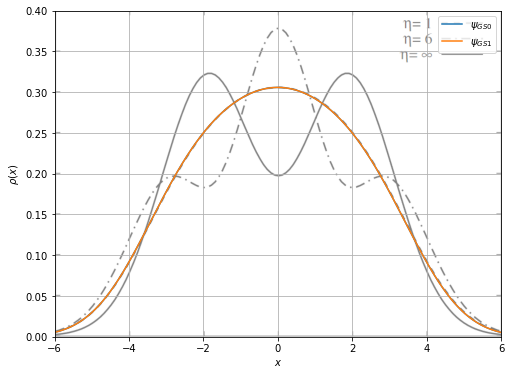

In [5]:
gs_0 = C[:, 0]
gs_1 = C[:, 1]
display(f"GS 0 coefs: {gs_0.real}".replace("\n", ""))
display(f"GS 1 coefs: {gs_1.real}".replace("\n", ""))

gs_vals_0 = np.zeros(num_grid_points, dtype = complex)
gs_vals_1 = np.zeros(num_grid_points, dtype = complex)
for i in range(system.l):
    gs_vals_0 += gs_0[i] * system.spf[i]
    gs_vals_1 += gs_1[i] * system.spf[i]


plt.figure(figsize=(8,6))
plt.plot(system.grid, np.abs(gs_vals_0)**2 / np.sum(np.abs(gs_vals_0)**2) * num_grid_points / 10, label=r"$\psi_{GS 0}$")
plt.plot(system.grid, np.abs(gs_vals_1)**2 / np.sum(np.abs(gs_vals_1)**2) * num_grid_points / 10, label=r"$\psi_{GS 1}$")

img=mpimg.imread('GS.PNG')
plt.imshow(img, extent=[-6, 6, 0, 0.4], aspect='auto', alpha = 0.5)

plt.xlim(-6, 6)
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho (x)$')
plt.grid()
plt.legend()
plt.show()

In [6]:
@njit
def expected_energy(C, h, u, n):
    l = C.shape[0]
    P = getP(C, n)
    
    energy = 0
    for a in range(l):
        for b in range(l):
            energy += P[b, a] * h[a, b]
            for c in range(l):
                for d in range(l):
                    energy += 0.5 * P[b, a] * P[d, c] * u[a, c, b, d]
    return energy.real

@njit
def expected_position(C, position, n):
    l = C.shape[0]
    P = getP(C, n)
    
    pos = 0
    for a in range(l):
        for b in range(l):
            pos += P[b, a] * position[0][a, b]
    return pos.real

In [7]:
print(f"GS energy: {expected_energy(C, system.h, system.u, system.n):.6f}")
print(f"Reference: {1.1795}")
print(f'"Exact"  : {0.8247}')

GS energy: 1.179579
Reference: 1.1795
"Exact"  : 0.8247


## TDHF

In [14]:
class RHS(object):
    def __init__(self, system, eps_0, omega_e, envelope = False, T = 1):
        self.system = system
        
        self.eps_0 = eps_0
        self.omega_e = omega_e
        if envelope:
            self.laser = self.envelope
            self.T = T
        else:
            self.laser = self.weak_laser
        
    def weak_laser(self, t):
        return self.eps_0 * np.sin(self.omega_e * t)
    
    def envelope(self, t):
        if t < self.T:
            return self.weak_laser(t) * np.sin(np.pi * t / self.T)**2
        else:
            return 0
    
    def __call__(self, t, C):
        system = self.system
        C = C.reshape(system.l, system.l)
        F = getF(C, system.h, system.u, system.n) - system.position[0] * self.laser(t)
        Cdot = -1j * F @ C

        return Cdot.reshape(-1)

In [15]:
def tdhf(C, system, f, t1, dt):
    # Setup integration parameters
    y0 = C.reshape(-1)
    t0 = 0
    N = int((t1 - t0) / dt) + 10 # making N large enough with good margin

    y = np.zeros((N, y0.shape[0]), dtype="c16")
    y[0] = y0
    t = np.zeros(N)
    t[0] = t0
    
    # Setting up integrator and performing integration
    r = complex_ode(f).set_integrator('vode')
    r.set_initial_value(y0, t0)
    i = 1
    while r.successful() and r.t < t1:
        y[i] = r.integrate(r.t + dt)
        t[i] = r.t
        i += 1

    # Removing the safety zeroes at the end
    t = t[:i]
    y = y[:i]
        
    return t, y

In [16]:
eps_0 = 1
omega_e = 8 * omega

t1 = 4 * 2 * np.pi / omega_e
dt = 0.001

f = RHS(system, eps_0, omega_e)
t, y = tdhf(C, system, f, t1, dt)

In [20]:
N = y.shape[0]
overlap = np.zeros(N)
energy = np.zeros(N)
pos = np.zeros(N)

C0 = C[:, 0:2] # Occupied columns of C at time 0
for i in range(N):
    Ci = y[i, :].reshape(system.l, system.l) # C at time i
    Ci_dag = np.conj(Ci[:,0:2]).T
    overlap[i] = np.abs(np.linalg.det(Ci_dag @ C0))**2 # overlap integral

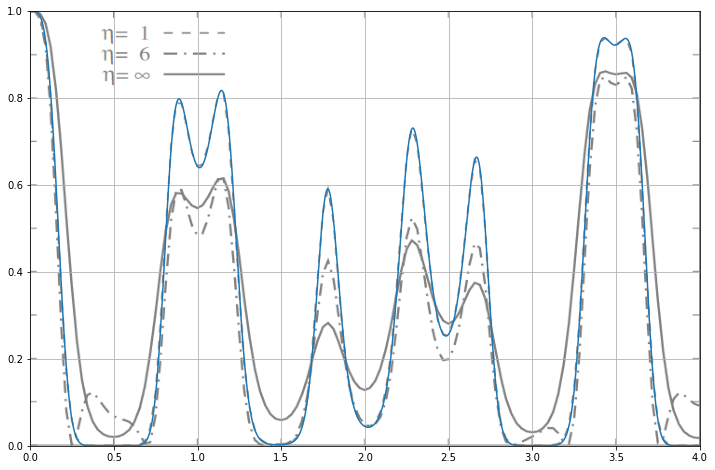

In [21]:
plt.figure(figsize=(12, 8))

unit = 2 * np.pi / omega_e
plt.plot(t / unit, overlap)

img=mpimg.imread('TD1.PNG')
plt.imshow(img, extent=[0, 4, 0, 1], aspect='auto', alpha = 0.5)

plt.grid()
plt.show()

## Experimenting with expectation values and animation

In [22]:
eps_0 = 0.1
omega_e = omega * 4

#t1 = 4 * 2 * np.pi / omega_e
t1 = 4 * 2 * np.pi / (omega * 8)
t1 *= 2
dt = 0.01

f = RHS(system, eps_0, omega_e)
t, y = tdhf(C, system, f, t1, dt)

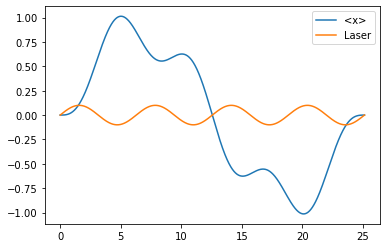

In [24]:
N = y.shape[0]
energy = np.zeros(N)
pos = np.zeros(N)

for i in range(N):
    Ci = y[i, :].reshape(system.l, system.l) # C at time i
    energy[i] = expected_energy(Ci, system.h, system.u, system.n)
    pos[i] = expected_position(Ci, system.position, system.n)

plt.plot(t, pos, label = "<x>")
plt.plot(t, f.laser(t), label = "Laser")
plt.legend()
plt.show()

In [25]:
times = [i for i in range(0, len(t), len(t)//200)] # choosing a selection of evenly spaced times to animate
wf_amp = np.zeros((len(times), system.spf.shape[1]))
wf_amp2 = np.zeros((len(times), system.spf.shape[1]))

for i, time_idx in enumerate(times):
    for wf, e_idx in zip([wf_amp, wf_amp2], [0, 1]):
        gs = y[time_idx, :].reshape(system.l, system.l)[:, 0]
        swf = np.zeros(system.spf.shape[1], dtype = "c16")
        for j in range(system.l):
            swf += gs[j] * system.spf[j]
        wf[i] = np.abs(swf)**2 / np.sum(np.abs(swf)**2) * num_grid_points / 10
    
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
plt.plot(system.grid, ODQD.HOPotential(omega)(system.grid), label = "HO")
line, = ax.plot(system.grid, wf_amp[0], label = r"$\psi_0$")
line2, = ax.plot(system.grid, wf_amp2[0], label = r"$\psi_1$")
plt.xlim(-6, 6)
plt.ylim(0, 0.4)
ax.legend()
ax.grid()

def update(i):
    line.set_ydata(wf_amp[i])
    line2.set_ydata(wf_amp2[i])

plt.close()

In [26]:
ani = animation.FuncAnimation(fig, update, frames = len(times), interval=30)
HTML(ani.to_jshtml())

## FFT

In [32]:
omega_2 = 0.25 # strength of harmonic oscillator potential

# this sets up the harmonic oscillator basis functions and integrals between them
odho_2 = ODQD(15, grid_length, num_grid_points, a = 0.25, alpha = 1, potential = ODQD.HOPotential(omega_2))

# this makes a spin up and spin down variant of the odho basis function and sets up the integrals between them
system_fft = GeneralOrbitalSystem(n = n, basis_set=odho_2)
C_fft = SCF(np.eye(system_fft.l), system_fft, 20)

In [33]:
eps_0 = 0.5
omega_e = omega_2 * 8

T = 2
t1 = 25 + T
dt = 0.1

In [34]:
f = RHS(system_fft, eps_0, omega_e, envelope = True, T = T)
t, y = tdhf(C_fft, system_fft, f, t1, dt)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

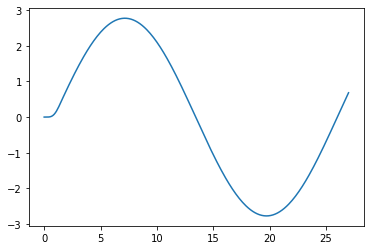

In [36]:
N = y.shape[0]
energy = np.zeros(N)
pos = np.zeros(N)

for i in range(N):
    Ci = y[i, :].reshape(system_fft.l, system_fft.l) # C at time i
    energy[i] = expected_energy(Ci, system_fft.h, system_fft.u, system_fft.n)
    pos[i] = expected_position(Ci, system_fft.position, system_fft.n)


plt.plot(t, pos, label = "<x>")
plt.plot(t, f.laser(t), label = "Laser")
plt.legend()
plt.show()

In [ ]:
N0 = int(T // dt) + 1
N1 = -30
signal = expectation_pos[N0:N1]
time = t[N0:N1]
N = len(time)

plt.figure(figsize=(12,8))
plt.subplot(221)

plt.plot(time, signal)
plt.title("Signal")
plt.xlabel("Tid [s]")
plt.ylabel("Amplitude")

plt.subplot(222)
freqs = np.fft.fftfreq(n = N, d = dt)[:N//2] * 2 * np.pi
fftGen = np.abs(np.fft.fft(signal) / N)[:N//2]

plt.plot(freqs, fftGen)
plt.title("Absolute value of FFT")
plt.xlabel("Frekvens [Hz]")
plt.xlim(0, omega_2 * 2)

plt.show()

In [ ]:
idx = np.argmax(np.abs(fftGen[:N//2]))
print(f"{freqs[idx]} +- {freqs[idx] - freqs[idx-1]}")